<h1 style="text-align:center;line-height:1.5em;font-size:30px;">Data and Scripts <br>for Hydrological Streamline Detection Using a U-net model</h1>
<p style="text-align:center;font-size:12px;">
$Zewei$ $Xu^{1,2,4}$, $Nattapon Jaroenchai^{1,2,4}$, $Arpan Man Sainju^{3,5}$; $Zhiyu Li^{1,2,4}$; $Larry Stanislawski^{6}$; $Ethan Shavers^{6}$; $Bin Su^{1,2,4}$; $Zhe Jiang^{3,5}$;$Shaowen Wang^{1,2,4}$
</p>
<p style="text-align:center;font-size:12px;">
$^{1}$$CyberGIS Center for Advanced Digital and Spatial Studies$<br>
$^{2}$$Department of Geography and Geographic Information Science$<br>
$^{3}$$Department of Computer Science$<br>
$^{4}$$University of Illinois at Urbana-Champaign$<br>
$^{5}$$University of Alabama$<br>
$^{6}$$U.S. Geological Survey$<br>
$Corresponding Author: zeweixu2@illinois.edu$
    </p>

---

**Notebook Structure:**
- [Introduction](1_introduction.ipynb)
- Codes
 - [Data Preprocessing](2.1_Code_Data_Preprocessing.ipynb)
 - [Model Training](2.2_Code_Model_Training.ipynb)
 - [Interpret the Result](2.3_Code_Interpret_the_Result.ipynb) 

---

### Interpret the Result

This notebook contains the code that we used to extract statistics and evaluate the result of CNN training. 

---

The cell below is to initiate the function that will be used to extract trainging and validating statistics during the CNN training. 

In [19]:
root = "./"
m='v2'
aug = '_aug'+m #+sys.argv[1] #'v2'

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import pickle
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.metrics import confusion_matrix

"""
plot_history(): reads Keras result and ogenerate figure of Loss, Dice Coefficient, and Accuracy.
"""
def plot_history(history):
    loss_list = [s for s in history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.keys() if 'loss' in s and 'val' in s]
    dice_list = [s for s in history.keys() if 'dice' in s and 'val' not in s]
    val_dice_list = [s for s in history.keys() if 'dice' in s and 'val' in s]
    acc_list = [s for s in history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history[loss_list[0]]) + 1)
    
    ## Loss
    plt.subplot(1,3,1)
    for l in loss_list:
        plt.plot(epochs, history[l], 'b', label='Training loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history[l], 'g', label='Validation loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Dice Coefficient
    plt.subplot(1,3,2)
    for l in dice_list:
        plt.plot(epochs, history[l], 'b', label='Training Dice Coefficient (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_dice_list:    
        plt.plot(epochs, history[l], 'g', label='Validation Dice Coefficient (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    ## Accuracy
    plt.subplot(1,3,3)
    for l in acc_list:
        plt.plot(epochs, history[l], 'b', label='Training accuracy (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history[l], 'g', label='Validation accuracy (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# **Plot the Result**

The plot is generated based on the log of the trainging and validating processes which contains the statistic of training and validating phases.

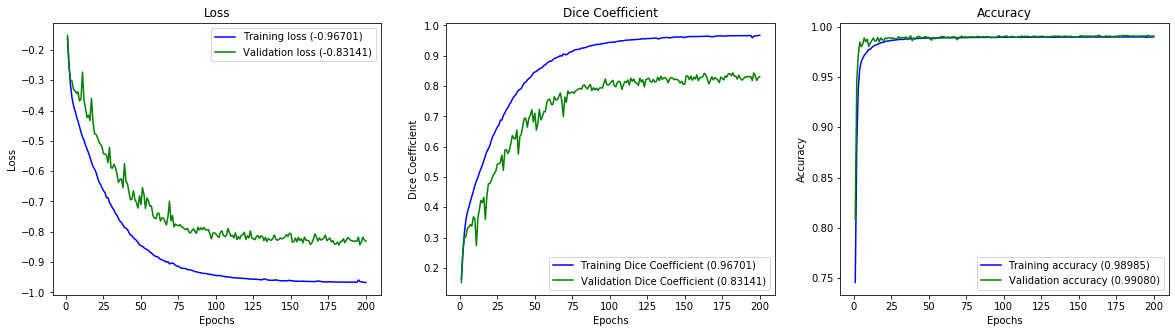

In [21]:
infile = open(root+'result/history_augn2_attention2.pickle','rb')
new_dict = pickle.load(infile)
infile.close()
plt.figure(figsize=(20,5))
plot_history(new_dict)

---

### Confusion matrix

The code below is used to generate the confusion matrix of the testing dataset. 

Confusion matrix, without normalization
[[6099525   47555]
 [  33826  110906]]


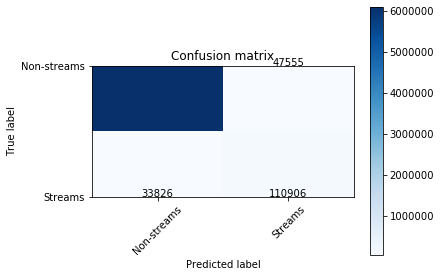

In [22]:
import copy
import random
import sys
import numpy as np

buf =30
"""
plot_confusion_matrix(): prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

preds_test_mod = np.load(root+'result/preds_test_total_augn2_attention2.npy')

dim = np.load(root+'data/reference.npy').shape
numr = dim[0]//(224 - buf*2)
numc = dim[1]//(224 - buf*2)
count = -1
for i in range(numr):
    for j in range(numc):
        count += 1    
        temp = preds_test_mod[count][buf:-buf,buf:-buf]
        if j == 0:
            rows = temp
        else:
            rows = np.concatenate((rows,temp),axis = 1)
    if i == 0:
        prediction_map = copy.copy(rows)
    else:
        prediction_map = np.concatenate((prediction_map,rows),axis = 0)
prediction_map = prediction_map[:,:,0]
# fig= plt.figure(figsize=(20,15))
# plt.imshow(prediction_map*255,cmap='gray',vmin=0, vmax=255)
# plt.show()

#print(np.unique(prediction_map))

# mask
mask = np.load(root+'data/mask.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
[lr,lc] = np.where(mask == 1)

# Read reference data
groundtruthlist = np.load(root+'data/reference.npy')[:prediction_map.shape[0],:prediction_map.shape[1]][lr,lc]
predictionlist = prediction_map[lr,lc]

# print(np.unique(groundtruthlist*255))
# print(np.unique(predictionlist))
# print(type(groundtruthlist))
# print(groundtruthlist)
# print(type(predictionlist))
# print(predictionlist)

cm = confusion_matrix((groundtruthlist).astype(int), predictionlist)
plot_confusion_matrix(cm,classes=["Non-streams","Streams"])


The cell below will calculate 3 statistics that can be used to evaluate the performance of the model. 

In [17]:
# Statistics
from sklearn.metrics import f1_score, precision_score,recall_score
#print(f1_score(groundtruthlist, predictionlist, average='macro'))
print('F1 score of stream: '+str(f1_score(groundtruthlist, predictionlist,pos_label=1)))
print('F1 score of nonstream: '+str(f1_score(groundtruthlist, predictionlist,pos_label=0)))
print('Precision of stream: '+str(precision_score(groundtruthlist, predictionlist,pos_label=1)))
print('Precision of nonstream: '+str(precision_score(groundtruthlist, predictionlist,pos_label=0)))
print('Recall of stream: '+str(recall_score(groundtruthlist, predictionlist,pos_label=1)))
print('Recall of nonstream: '+str(recall_score(groundtruthlist, predictionlist,pos_label=0)))

F1 score of stream: 0.7315868110411521
F1 score of nonstream: 0.9933731153246983
Precision of stream: 0.6998946112923685
Precision of nonstream: 0.994484907190213
Recall of stream: 0.7662852720891026
Recall of nonstream: 0.9922638065553075


The cell below is the code that show the result compare to the reference dataset 

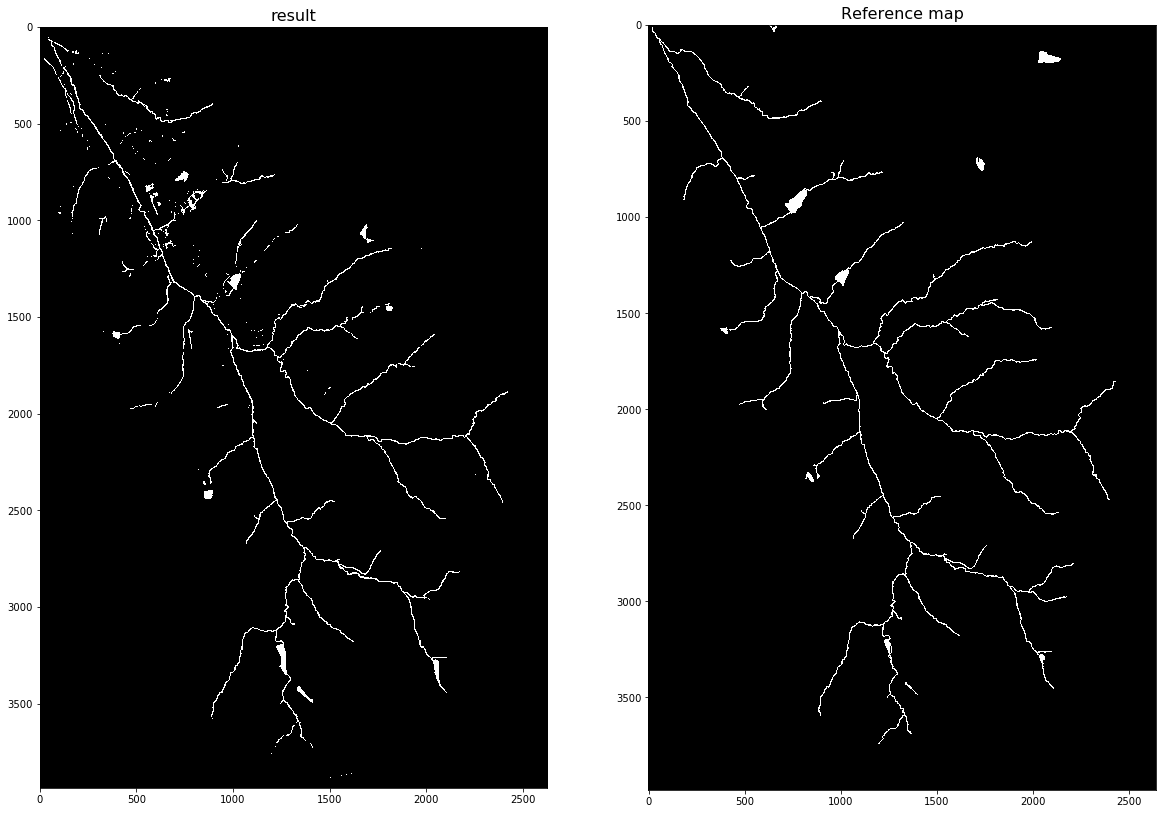

In [23]:
# Generate prediction map
from osgeo import gdal    
import numpy as np
import copy
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(20,15))

# Plot the map
prediction_map = prediction_map*mask
plt.subplot(1,2, 1)
plt.title('result',fontsize = 16)
plt.imshow(prediction_map*255,cmap='gray',vmin=0, vmax=1)

reference = np.load(root+'data/reference.npy')
plt.subplot(1,2,2)
plt.title('Reference map',fontsize = 16)
plt.imshow(reference*255,cmap='gray',vmin=0, vmax=255)
plt.show()
